**III. Thư viện XGBoost tích hợp sẵn**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

**III.1 Dự đoán giá xe cũ (bài toán hồi quy)**

In [2]:
from xgboost import XGBRegressor
import re
import pandas as pd
def pre_processing(data):
    categorical_cols = ['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Drivetrain']
    mappings = {}

    for col in categorical_cols:
        data[col] = data[col].fillna('Unknown').astype(str)
        unique_vals = sorted(data[col].unique())
        mappings[col] = {val: idx for idx, val in enumerate(unique_vals)}
        data[col] = data[col].map(mappings[col])

    special_cols = ['Max Power', 'Max Torque']
    for col in special_cols:
        data[col] = data[col].apply(lambda x: re.findall(r'^\d+\.?\d*', str(x))[0] if pd.notna(x) and re.findall(r'^\d+\.?\d*', str(x)) else '0')
        data[col] = data[col].astype(float)

    numerical_cols = ['Year', 'Kilometer', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
    for col in numerical_cols:
        data[col] = data[col].astype(float)
    #xử lí các cột Engine, age (=2024 - Year),seating Capacity và fuel tank capacity
    data['Fuel Tank Capacity'].fillna(data['Fuel Tank Capacity'].mean(), inplace=True)
    data['Engine'] = data['Engine'].str.split(' ', expand = True)[0].astype(float)
    data['Engine'].fillna(data['Engine'].mean(), inplace=True)
    data['age'] = 2024 - data['Year']
    data['Seating Capacity'].bfill(inplace=True)
    #Xử lí cột Make-Num (bằng `xếp hạng` thứ tự giá trung bình các `hãng xe` rồi gán cho từng cột tương ứng với các hãng)
    #print(data['Make'])
    make_rank = data[['Make', 'Price']].groupby('Make').mean().rank()
    data['Make-Num'] = data['Make'].map(make_rank['Price'])
    data['Make-Num']
    #print(make_rank)
    # data['Make-Num'] = 0
    # for make in make_rank['Make']:
    #     data.loc[data['Make'] == make,'Make-Num'] = make_rank.loc[make]
    # data.info()
data = pd.read_csv("train.csv")
print(data.head())
pre_processing(data)

            Make                            Model     Price  Year  Kilometer  \
0            BMW                    3-Series 320d    800000  2012      75576   
1            BMW               X1 sDrive20d xLine   2199000  2016      77000   
2       Mahindra                   XUV500 W4 1.99    800000  2017     112000   
3  Mercedes-Benz                  GLS 400d 4MATIC  12900000  2021       3000   
4         Toyota  Fortuner 2.8 4x2 AT [2016-2020]   3499000  2019      73000   

  Fuel Type Transmission     Location   Color   Owner Seller Type   Engine  \
0    Diesel    Automatic       Mumbai   White  Second  Individual      NaN   
1    Diesel    Automatic        Surat   Black   First  Individual  1995 cc   
2    Diesel       Manual  Muzaffurpur  Silver   First  Individual  1997 cc   
3    Diesel    Automatic        Delhi   White   First  Individual  2925 cc   
4    Diesel    Automatic       Mumbai   White   First  Individual  2755 cc   

            Max Power         Max Torque Drivetrai

In [3]:
from sklearn.model_selection import train_test_split
y = data['Price'].fillna(0)
X = data.drop('Price', axis=1)
X = X.replace([np.inf, -np.inf], 0).fillna(0)
# Loại cột có tương quan cao (> 0.9)
correlation_matrix = X.corr()
high_corr = set()
corr_threshold = 0.9
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr.add(colname)
if len(high_corr) > 0:
    X = X.drop(columns=high_corr)
#huấn luyện mô hình
params = {
    'eval_metric':      'error', 
    'learning-rate':    0.1,    
    'n_estimators':     300,      
    'max_depth':        3,    
    'gamma':            0.5,   
    'min_child_weight': 1,  
    'subsample':        0.8,   
    'colsample_bytree': 0.8,   
    'reg_alpha':        1.0,   
    'reg_lambda':       1.0,         
    'scale_pos_weight': 1               
}
xgb_rg = XGBRegressor(**params)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
xgb_rg.fit(X_train,y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='error', feature_types=None,
             gamma=0.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning-rate=0.1,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

--- Đánh giá mô hình (tập train) ---

Mean Squared Error (MSE): 6548146381.21
Coefficient of Determination (R²): 0.999


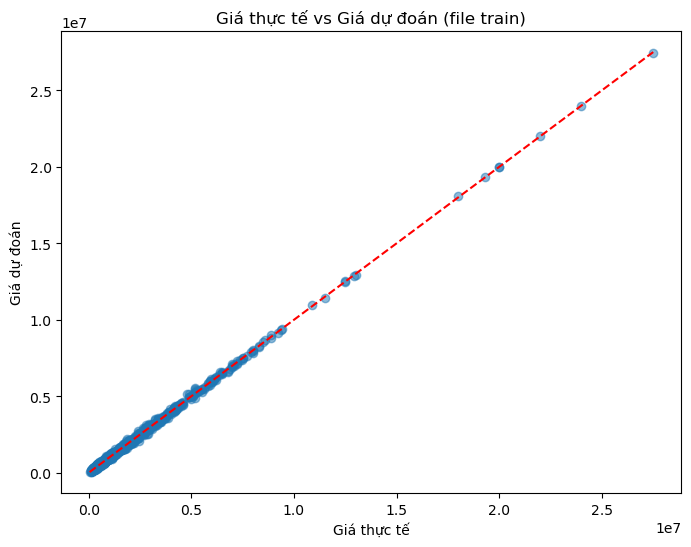

--- Đánh giá mô hình (tập test) ---

Mean Squared Error (MSE): 722708435579.11
Coefficient of Determination (R²): 0.851


Text(0.5, 1.0, 'Giá thực tế vs Giá dự đoán (file test)')

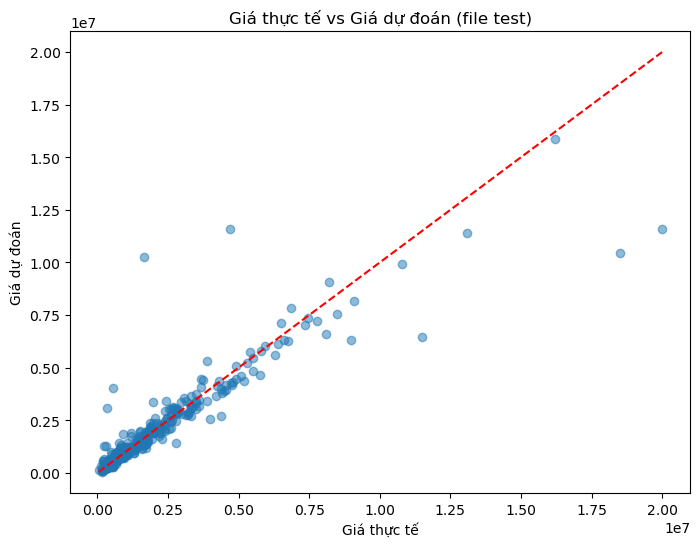

In [5]:
#dự đoán (file train)
y_pred = xgb_rg.predict(X_train)
y_vec = y_train.values
mse = np.mean((y_vec - y_pred) ** 2)
rss = np.sum((y_vec - y_pred) ** 2)  # Residual Sum of Squares
tss = np.sum((y_vec - np.mean(y_vec)) ** 2)  # Total Sum of Squares
r_squared = 1 - (rss / tss)
print("--- Đánh giá mô hình (tập train) ---")
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r_squared:.3f}")
actual_prices = y_vec
predicted_prices = y_pred
min_val = min(np.min(actual_prices), np.min(predicted_prices))
max_val = max(np.max(actual_prices), np.max(predicted_prices))
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Vẽ đường y = x
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Giá thực tế vs Giá dự đoán (file train)')
plt.show()
#dự đoán (file test)
y_pred = xgb_rg.predict(X_test)
y_vec = y_test.values
mse = np.mean((y_vec - y_pred) ** 2)
rss = np.sum((y_vec - y_pred) ** 2)  # Residual Sum of Squares
tss = np.sum((y_vec - np.mean(y_vec)) ** 2)  # Total Sum of Squares
r_squared = 1 - (rss / tss)
print("--- Đánh giá mô hình (tập test) ---")
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r_squared:.3f}")
actual_prices = y_vec
predicted_prices = y_pred
min_val = min(np.min(actual_prices), np.min(predicted_prices))
max_val = max(np.max(actual_prices), np.max(predicted_prices))

plt.figure(figsize=(8, 6))
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Vẽ đường y = x
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Giá thực tế vs Giá dự đoán (file test)')

**III.2 Dự đoán ung thư hay không (bài toán phân loại)**

In [6]:
data = 'ABIDE2(updated).csv'

df = pd.read_csv(data)
df['num'] = (df['group'] == 'Cancer').astype(int)
X = df.drop(['site', 'age', 'group', 'num'], axis=1)

y = df['num']
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Chuẩn hóa dữ liệu
X_std = StandardScaler().fit_transform(X)

# Khởi tạo và fit mô hình PCA của scikit-learn
sklearn_pca = PCA(n_components=190)
sklearn_pca.fit(X_std)
X_sklearn = sklearn_pca.transform(X_std)
X_sklearn.shape

(1004, 190)

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sklearn, y, test_size = 0.3, random_state = 0)
from xgboost import XGBClassifier

# declare parameters
params = {
    'objective':        'binary:logistic',
    'eval_metric':      'error',        
    'learning_rate':    0.05,            
    'n_estimators':     300,            
    'max_depth':        3,             
    'gamma':            0.5,          
    'min_child_weight': 1,    
    'subsample':        0.8,    
    'colsample_bytree': 0.8,        
    'reg_alpha':        1.0,  
    'reg_lambda':       1.0,    
    'scale_pos_weight': 1 
}
            
            
xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
y_pred = xgb_clf.predict(X_train)

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
y_pred = xgb_clf.predict(X_train)
y_pred
print('Train file: ')
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred)))
print('XGBoost model precision score: {0:0.4f}'. format(precision_score(y_train, y_pred)))
print('XGBoost model recall score: {0:0.4f}'. format(recall_score(y_train, y_pred)))
print('XGBoost model f1-score score: {0:0.4f}'. format(f1_score(y_train, y_pred)))

Train file: 
XGBoost model accuracy score: 1.0000
XGBoost model precision score: 1.0000
XGBoost model recall score: 1.0000
XGBoost model f1-score score: 1.0000


In [10]:
print('Test file: ')
y_pred = xgb_clf.predict(X_test)
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('XGBoost model precision score: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('XGBoost model recall score: {0:0.4f}'. format(recall_score(y_test, y_pred)))
print('XGBoost model f1-score score: {0:0.4f}'. format(f1_score(y_test, y_pred)))

Test file: 
XGBoost model accuracy score: 0.6126
XGBoost model precision score: 0.6061
XGBoost model recall score: 0.5517
XGBoost model f1-score score: 0.5776
